In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare_norm
0,0,0,1,0,1,0,0,1,-0.563674,0.431350,-0.474326,-0.877591
1,1,0,0,1,0,1,0,0,0.669217,0.431350,-0.474326,1.366380
2,0,0,1,1,0,0,0,1,-0.255451,-0.475199,-0.474326,-0.796281
3,1,0,0,1,0,0,0,1,0.438050,0.431350,-0.474326,1.066796
4,0,0,1,0,1,0,0,1,0.438050,-0.475199,-0.474326,-0.781901


### Building the initial model
First, an initial model will be defined through the function neural_model. Some cross-validation will be employed to establish a baseline metric (accuracy score).

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [5]:
# Function defining the model
def neural_model(hidden_layers=[7], act='relu', opt='adam', dropout=0.0):
    # To maintain reproducibility
    tf.random.set_seed(101)
    
    model = Sequential()
    
    # First layer
    model.add(Dense(units=hidden_layers[0], input_dim=X_train.shape[1], activation=act))
    
    # Hidden layers
    for i in range(1,len(hidden_layers)):
        model.add(Dense(units=hidden_layers[i], activation=act))
    
    # Dropout
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Finalizing
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [131]:
model = create_model()
print(model.summary())

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 8)                 104       
_________________________________________________________________
dropout_113 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_271 (Dense)            (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None


In [132]:
# Training the initial model with a 80/20 data split
init_train = model.fit(X_train, np.ravel(y_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [133]:
print('\n%s: %.2f%%' % ('Mean accuracy', np.mean(init_train.history['val_accuracy'])*100))


Mean accuracy: 83.07%


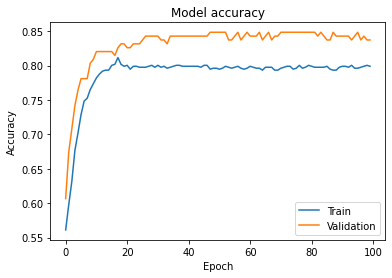

In [124]:
plt.plot(init_train.history['accuracy'])
plt.plot(init_train.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

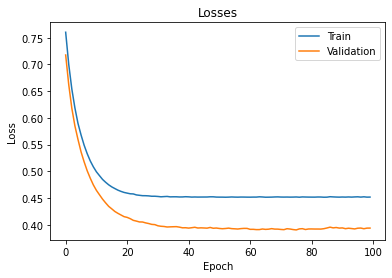

In [125]:
plt.plot(init_train.history['loss'])
plt.plot(init_train.history['val_loss'])
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

### Grid search
Next, some grid search will be performed to test some options for the hyperparameters of the model and try to improve the score.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [16]:
def tuned_model(best_grid):
    print('Tuned score: %f' % best_grid.best_score_)
    print('Tuned parameters: %s' % best_grid.best_params_)

In [20]:
neural = KerasClassifier(build_fn=neural_model, verbose=0)
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100, 200],
    'hidden_layers': [(7,), (10,), (7,7), (10,10), (10,5), (14,7)],
    'dropout': [0.0, 0.01, 0.05, 0.1, 0.5]
    }

RS_grid = RandomizedSearchCV(neural, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1)
best_RS_grid = RS_grid.fit(X_train, np.ravel(y_train))

tuned_model(best_RS_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.0min finished


Tuned score: 0.823488
Tuned parameters: {'hidden_layers': (7,), 'epochs': 200, 'dropout': 0.01, 'batch_size': 32}


In [21]:
neural = KerasClassifier(build_fn=neural_model, verbose=0)
param_grid = {
    'batch_size': [16, 32],
    'epochs': [100, 200],
    'hidden_layers': [(7,), (10,), (7,7), (10,10)],
    'dropout': [0.0, 0.01, 0.05]
    }

grid = GridSearchCV(neural, param_grid, cv=5, verbose=2, n_jobs=-1)
best_grid = grid.fit(X_train, np.ravel(y_train))

tuned_model(best_grid)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.0min finished


Tuned score: 0.824618
Tuned parameters: {'batch_size': 16, 'dropout': 0.0, 'epochs': 200, 'hidden_layers': (7,)}


In [23]:
model_1 = neural_model(hidden_layers=(7,), dropout=0.01)
model_2 = neural_model(hidden_layers=(7,), dropout=0.0)

train_1 = model_1.fit(X_train, np.ravel(y_train), epochs=200, batch_size=32, validation_split=0.2, verbose=0)
train_2 = model_2.fit(X_train, np.ravel(y_train), epochs=200, batch_size=16, validation_split=0.2, verbose=0)

In [74]:
print('\n%s: %.2f%%' % ('Mean accuracy (model 1)', np.mean(train_1.history['val_accuracy'])*100))
print('\n%s: %.2f%%' % ('Mean accuracy (model 2)', np.mean(train_2.history['val_accuracy'])*100))


Mean accuracy (model 1): 85.88%

Mean accuracy (model 2): 87.12%


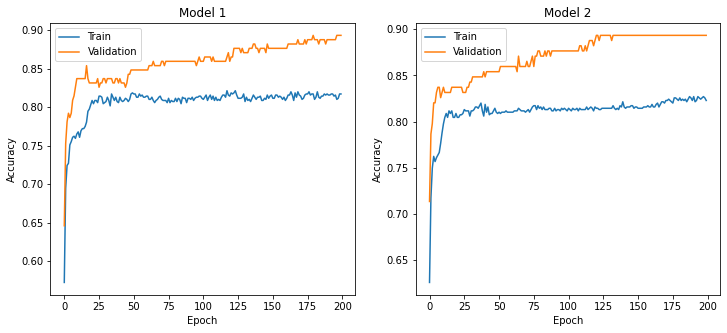

In [35]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.lineplot(ax=ax[0],data=train_1.history['accuracy'])
sns.lineplot(ax=ax[0],data=train_1.history['val_accuracy'])
ax[0].set_title('Model 1')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

sns.lineplot(ax=ax[1],data=train_2.history['accuracy'])
sns.lineplot(ax=ax[1],data=train_2.history['val_accuracy'])
ax[1].set_title('Model 2')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Validation'])

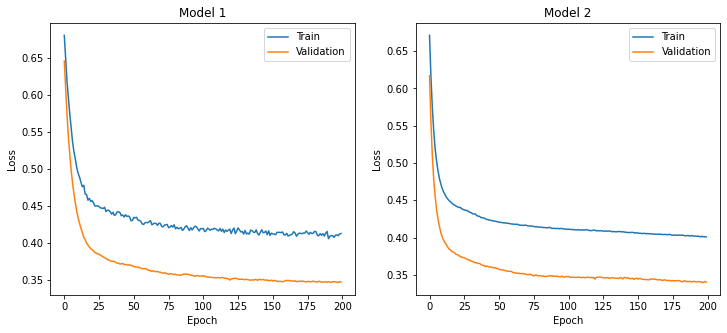

In [36]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.lineplot(ax=ax[0],data=train_1.history['loss'])
sns.lineplot(ax=ax[0],data=train_1.history['val_loss'])
ax[0].set_title('Model 1')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Validation'])

sns.lineplot(ax=ax[1],data=train_2.history['loss'])
sns.lineplot(ax=ax[1],data=train_2.history['val_loss'])
ax[1].set_title('Model 2')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

In [73]:
y_pred_1 = (model_1.predict(X_test) > 0.5).astype(int)
y_pred_2 = (model_2.predict(X_test) > 0.5).astype(int)

test = pd.read_csv('test_original.csv')

neural_submission_1 = pd.DataFrame()
neural_submission_2 = pd.DataFrame()

neural_submission_1['PassengerId'] = test['PassengerId']
neural_submission_2['PassengerId'] = test['PassengerId']

neural_submission_1['Survived'] = y_pred_1
neural_submission_2['Survived'] = y_pred_2

neural_submission_1.to_csv('NeuralNetworkSubmission_Model1.csv', index=False)
neural_submission_2.to_csv('NeuralNetworkSubmission_Model2.csv', index=False)

### Summary
After grid search, I tried two models. Even though model 1 had a lower accuracy score, its predictions are slightly more correct than those obtained with model 2, as seen in the following table.

|Model|Accuracy|Correct predictions|
|:-|-:|-:|
|Model 1| 85.88%| 77.03%|
|Model 2| 87.12%| 76.79%|